In [1]:
import sys,os


In [2]:
import AtmosphericBlocking
import numpy as np
import h5py
import glob
import matplotlib.pyplot as plt
%matplotlib inline

/home/adiv/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The equation our model solves is $$\frac{\partial}{\partial t}\hat{A}(x,t) = - \frac{\partial}{\partial x}\left[\left(C(x)-\alpha\hat{A}\right)\hat{A}\right]+\hat{S}-\frac{\hat{A}}{\tau}+D\frac{\partial^2\hat{A}}{\partial x^2}$$

There are two directions in which we can explore this: forcing and background conditions (set by $C(x)$).

The background $C(x)$ is defined as $$C(x) = u_\text{ref} + c_g - 2\alpha A_0(x)$$
where $$A_0(x) = Y\left[1-\cos\left(\frac{2\pi nx}{L_x}\right)\right]$$ where $Y$ is the amplitude and $n$ is the wavenumber of the background stationary wave $A_0$.

The total LWA is $$A = A_0+\hat{A}.$$

Zonal LWA flux is defined as $$F(x,t) = \left(C(x)-\alpha\hat{A}(x,t)\right)\hat{A}(x,t)$$
while eastward wind $u(x,t)$ is defined as $$u(x,t) = 40-\alpha A.$$

So if we want to vary $C(x)$, there are three things we can play with:
  * $\beta = u_\text{ref} + c_g$
  * $Y$
  * $n$

In [3]:
def gaussforce(x,t,peak=2,inject=True,tw=2.5,xw=2800.0e3,xc=16800.0e3,tc=277.8):
  # Gaussian centered at 277.8 days and 16,800 km
    tc = tc
    tw = tw
    t = t/86400.0
    xc = xc
    xw = xw
    sx = 1.852e-5 + np.zeros(len(x))
    if inject:
        sx *= (1+peak*np.exp(-((x-xc)/xw)**2 - ((t-tc)/tw)**2))
    return sx

In [4]:
def force_all(x,t,peak=2,inject=True,tw=2.5,xw=2800.0e3,xc=16800.0e3,tc=277.8):
  # Gaussian centered at 277.8 days
    tc = tc
    tw = tw
    t = t/86400.0
    xc = xc
    xw = xw
    sx = 1.852e-5 + np.zeros(len(x))
    if inject:
        sx *= (1+peak*np.exp(- ((t-tc)/tw)**2))
    return sx

In [5]:
def noboru_cx(x,Lx,alpha):
  # The background conditions used in Noboru's paper
    A0 = 10*(1-np.cos(4*np.pi*x/Lx))
    cx = 60 - 2*alpha*A0
    return cx,A0

In [6]:
def noiseforce(x,t,peak=2,inject=True,freqs=np.arange(10),speeds=np.arange(10),phases=np.zeros(10),ampls=np.ones(10),Lx=28000.0e3,
              tw=2.5,xw=2800.0e3,xc=16800.0e3,tc=277.8):
    if t/86400<270:
        return np.zeros(x.shape)+1.852e-5
    sx = np.zeros(x.shape)
    wampls = ampls*peak
    for i in range(0,len(freqs)):
        sx += 1.0/len(freqs)*wampls[i]*np.sin(2*np.pi*freqs[i]*x/Lx+speeds[i]*t+phases[i])
    sx = 1.852e-5*np.maximum(1,(1 + sx**3))
    return sx

In [7]:
class conditions:
    def __init__(self,peak=2,inject=True,Y=10,beta=60,n=2,alpha=0.55,tau=10.0,sfunc=None,
                 xc=16800.0e3,xw=2800.0e3,tw=2.5,tc=277.8,noisy=False):
        self.peak = peak
        self.inject=inject
        self.Y = Y
        self.sfunc=sfunc
        self.tw = tw
        self.tc = tc
        self.xc = xc
        self.xw = xw
        self.noisy=noisy
        if not sfunc:
            self.sfunc=gaussforce
        self.tau = tau*86400.0
        self.beta = beta
        self.n=n
        self.alpha = alpha
    def forcing(self,x,t,peak=None,inject=None):
        if peak:
            self.peak = peak
        if inject:
            self.inject = inject
        sx = self.sfunc(x,t,peak=self.peak,inject=self.inject,tw=self.tw,xc=self.xc,
                        xw=self.xw,tc=self.tc)
        return sx
    def getcx(self,x,Lx,alpha=None,time=None):
        if alpha:
            self.alpha = alpha
        A0 = self.Y*(1-np.cos(2*self.n*np.pi*x/Lx))
        cx = self.beta - 2*self.alpha*A0
        return cx,A0

In [8]:
class noisyconditions:
    def __init__(self,peak=2,Y=10,beta=60,n=2,background=True,forcing=True,nwforce=26,nwcx=10,maxforcex=20,maxA0x=6,forcedecay=20,A0decay=60,alpha=0.55,
                 tc=277.8,tw=2.5,xc=16800.0e3,xw=2800.0e3,sfunc=None,cfunc=None,inject=True,cxpeak=0.5,tau=10.0):
        self.peak = peak
        self.cxpeak = cxpeak
        self.inject=inject
        self.Y = Y
        self.sfunc=sfunc
        self.tw = tw
        self.tc = tc
        self.xc = xc
        self.xw = xw
        self.background=background
        self.forcingbool=forcing
        self.cfunc=cfunc
        self.tau = tau*86400.0
        if not sfunc and not forcing:
            print(forcing,sfunc)
            self.sfunc=gaussforce
        elif not sfunc and forcing:
            self.sfunc = noiseforce
        self.beta = beta
        self.n=n
        self.alpha = alpha
        if forcing:
            self.ffreqs = np.random.randint(1,maxforcex,size=nwforce)
            self.fspeeds = 2.0*np.pi/(forcedecay*86400.0) - 4*np.pi/(forcedecay*86400.0)*np.random.rand(nwforce)  
            self.fphases = np.random.rand(nwforce)*2*np.pi
            self.fampls = 3.7*np.random.rand(nwforce) #6.8
        if background:
            self.cfreqs = np.random.randint(1,maxA0x,size=nwcx)
            self.cspeeds = 2.0*np.pi/(A0decay*86400.0) - 4*np.pi/(A0decay*86400.0)*np.random.rand(nwcx)  
            self.cphases = np.random.rand(nwcx)*2*np.pi
            self.campls = np.random.rand(nwcx)
        
        
    def forcing(self,x,t,peak=None,inject=None):
        if peak:
            self.peak = peak
        if inject:
            self.inject = inject
        if not self.forcingbool:
            sx = self.sfunc(x,t,peak=self.peak,inject=self.inject,tw=self.tw,xc=self.xc,
                            xw=self.xw,tc=self.tc)
        else:
            sx = self.sfunc(x,t,peak=self.peak,freqs=self.ffreqs,speeds=self.fspeeds,phases=self.fphases,ampls=self.fampls)
        return sx
    def getcx(self,x,Lx,alpha=None,time=None):
        if alpha:
            self.alpha = alpha
        A0 = self.Y*(1-np.cos(2*self.n*np.pi*x/Lx))
        if self.background:
            A0 *= self.cfunc(x,Lx,t=time,freqs=self.cfreqs,speeds=self.cspeeds,phases=self.cphases,ampls=self.cxpeak*self.campls)
        cx = self.beta - 2*self.alpha*A0
        
        return cx,A0

In [9]:
def noisybackground(x,Lx,t=None,freqs=None,speeds=None,phases=None,ampls=None):
    dcx = np.zeros(len(x))
    for i in range(0,len(freqs)):
        dcx += 1.0/len(freqs)*ampls[i]*np.sin(2*np.pi*freqs[i]*x/Lx+speeds[i]*t+phases[i])
    return (1+dcx)

In [12]:
noisy_initc = noisyconditions(nwcx=21,maxA0x=10,A0decay=40,cfunc=noisybackground,cxpeak=0.5,peak=2.0,background=True,forcing=True)

### Note: Following cell deletes output folder. May want to turn off.

In [13]:
cleanup = True
if cleanup:
    os.system("rm -rf output/")

In [14]:
cond = noisy_initc

In [15]:
model = AtmosphericBlocking.Model(nx=1024,Lx = 28000e3,dt=.005*86400,alpha=cond.alpha,
                                        tmax=3.5*86400,D=3.26e5,tau=cond.tau,
                                        sfunc=cond.forcing,cfunc=cond.getcx,
                                        forcingpeak=cond.peak,injection=cond.inject,
                                        save_to_disk=True,
                                        overwrite=True,
                                        tsave_snapshots=50,
                                        path = 'output/')

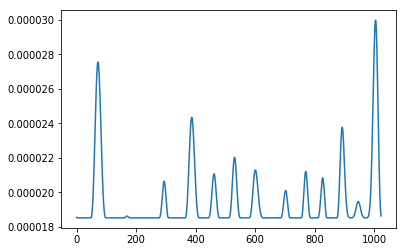

In [16]:
plt.plot(model.sfunc(model.x,280.0*86400.0))

In [17]:
model.tmax = 450*86400
model.run()

In [18]:

setup = h5py.File("output/setup.h5")
x = setup['grid/x'][:]

In [19]:
fnis = np.array(sorted(glob.glob("output/snapshots/*.h5")))

In [20]:
Ahat, F, S, C = 0,0,0,0
t = []
for fni in fnis[0::2]:
    snap = h5py.File(fni)
    t.append(snap['t'][()])
    try:
        Ahat = np.vstack([Ahat, snap['A'][:]])
        F = np.vstack([F, snap['F'][:]])
        S = np.vstack([S, snap['S'][:]])
        C = np.vstack([C, snap['C'][:]])
    except:
        Ahat = snap['A'][:]
        F = snap['F'][:]
        S = snap['S'][:]
        C = snap['C'][:]

t = np.array(t)

In [21]:
fnis.shape

(1800,)

In [22]:
t.shape

(900,)

In [23]:
print(Ahat.shape,model.A0.shape,F.shape)

(900, 1024) (1024,) (900, 1024)


In [24]:
print(np.where(t/86400 > 260)[0][0])
it0 = np.where(t/86400 > 260)[0][0]

520


Text(0.5,1,'S')

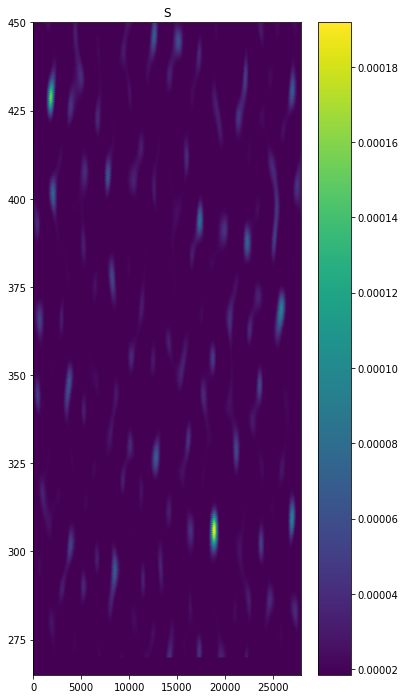

In [25]:
fig,ax=plt.subplots(figsize=(6.,12.))
plt.pcolormesh(x/1e3,t[it0:]/86400,(S[it0:]),shading='Gouraud',cmap='viridis')
plt.ylim(265,450)
plt.colorbar()
plt.title("S")

Text(0.5,1,'C')

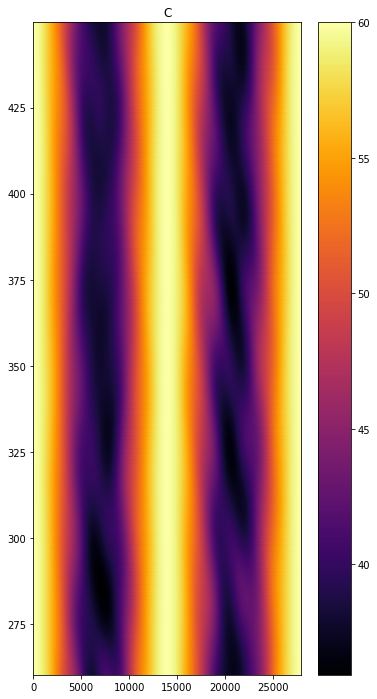

In [26]:
fig,ax=plt.subplots(figsize=(6.,12.))
plt.pcolormesh(x/1e3,t[it0:]/86400,(C[it0:]),shading='Gouraud',cmap='inferno')
#plt.ylim(270,300)
#plt.xlim(7000,12000)
plt.colorbar()
plt.title("C")

Text(0.5,1,'F')

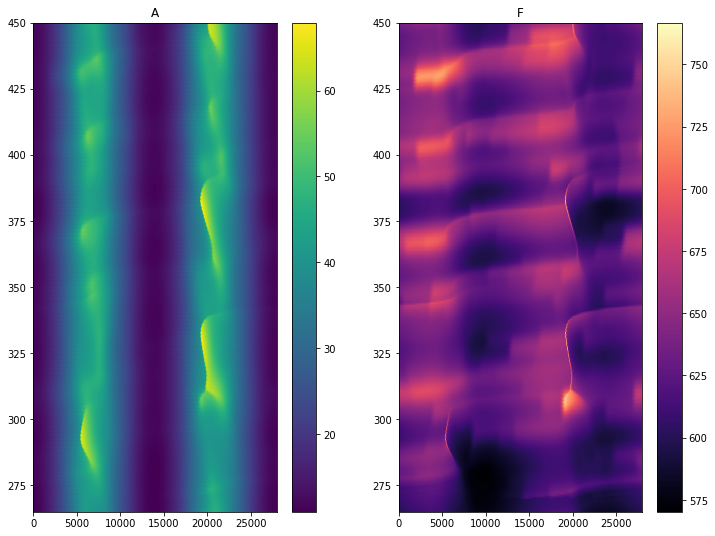

In [27]:
plt.figure(figsize=(12.,9))
plt.subplot(121)
plt.pcolormesh(x/1e3,t[it0:]/86400,(Ahat+model.A0[np.newaxis,:])[it0:],shading='Gouraud',cmap='viridis')
plt.ylim(265,450)
plt.colorbar()
plt.title("A")

plt.subplot(122)
plt.pcolormesh(x/1e3,t[it0:]/86400,F[it0:],shading='Gouraud',cmap='magma')
plt.ylim(265,450)
plt.colorbar()
plt.title("F")

In [29]:
ua = 40-cond.alpha*(Ahat+model.A0[np.newaxis,:])

Text(0.5,1,'Eastward Wind')

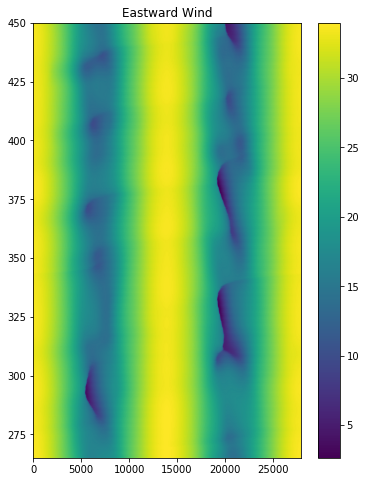

In [30]:
plt.figure(figsize=(6.,8))
plt.pcolormesh(x/1e3,t[it0:]/86400,(ua)[it0:],shading='Gouraud',cmap='viridis')
plt.colorbar()
plt.ylim(265,450)
plt.title("Eastward Wind")

In [32]:
gamma = 4*cond.alpha*F/C**2

The flux saturation $\Gamma(x,t)$ is defined as $$\Gamma(x,t) = \frac{4\alpha F(x,t)}{C^2(x)}.$$

0.9999999993010522


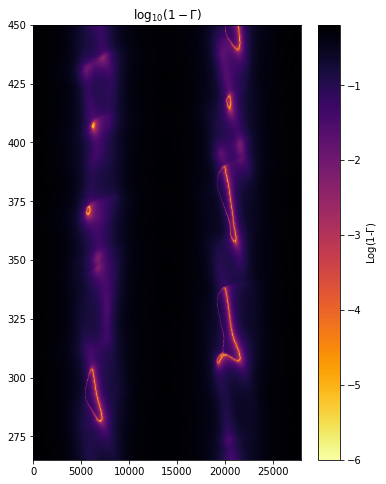

In [33]:
plt.figure(figsize=(6.,8))
im=plt.pcolormesh(x/1e3,t[it0:]/86400,np.log10(np.maximum(1.0-(gamma)[it0:],1.0e-6)),shading='Gouraud',cmap='inferno_r')
plt.colorbar(im,label="Log(1-$\Gamma$)")
#plt.contour(x/1e3,t[it0:]/86400,(gamma)[it0:],0.99999,colors='g')
plt.ylim(265,450)
plt.title("$\log_{10}(1-\Gamma)$")
print(gamma.max())

In [34]:
masked = gamma[:]
masked[np.where(gamma<0.99999)]=0
masked[np.where(gamma>=0.99999)]=1

Text(0.5,1,'Flux Saturated Yes/No')

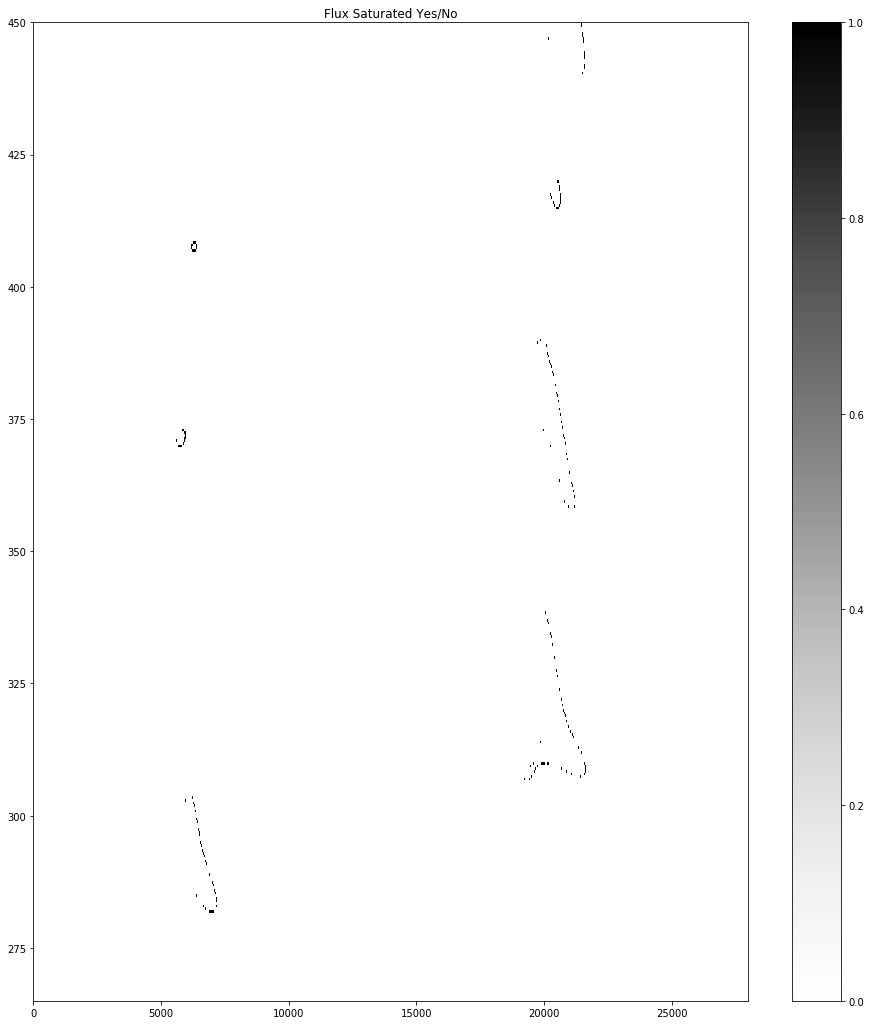

In [35]:

plt.figure(figsize=(16.,18))
plt.pcolormesh(x/1e3,t[it0:]/86400,(masked)[it0:],cmap='Greys')
plt.colorbar()
plt.ylim(265,450)
plt.title("Flux Saturated Yes/No")

In [36]:
def count_blocks(mask,dx,dt):
    dsh = mask.shape
    nt = dsh[0]
    nx = dsh[1]
    dmask = np.zeros(np.array(mask.shape)+[2*dt,2*dx])
    dmask[dt:-dt,dx:-dx] = mask[:,:]
    dmask[dt:-dt,0:dx] = mask[:,-dx:]
    dmask[dt:-dt,-dx:] = mask[:,0:dx]
    
    ict = 0
    for it in range(nt+dt,dt,-1):
        for ix in range(dx,nx+dx):
            if dmask[it,ix]==1:
                if np.sum(dmask[it-dt:it+dt,ix-dx:ix+dx])>1:
                    dmask[it,ix]=0
    
    ict = np.sum(dmask[dt:-dt,dx:-dx])
    return ict,dmask[dt:-dt,dx:-dx]

Text(0.5,1,'$|\\partial_t A|$')

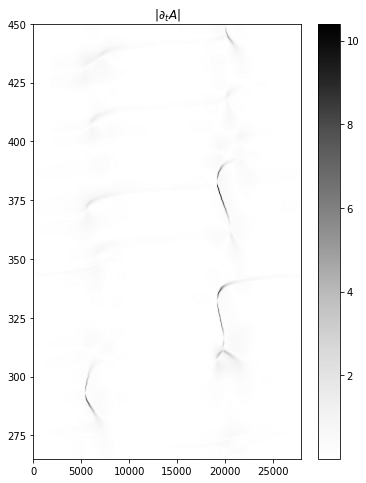

In [37]:
plt.figure(figsize=(6.,8))
plt.pcolormesh(x/1e3,t[it0:]/86400,abs(np.gradient((Ahat+model.A0[np.newaxis,:])[it0:],axis=0)),shading='Gouraud',cmap='Greys')
plt.colorbar()
plt.ylim(265,450)
plt.title("$|\partial_t A|$")

Text(0.5,1,'$|\\partial_x F|$')

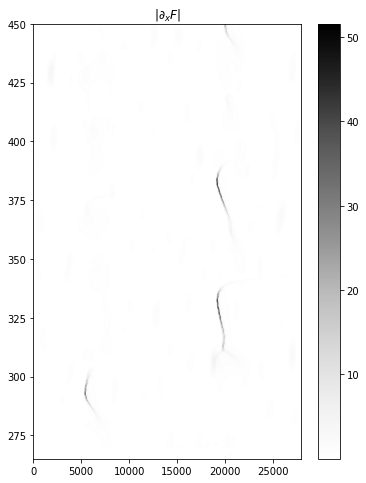

In [38]:
plt.figure(figsize=(6.,8))
plt.pcolormesh(x/1e3,t[it0:]/86400,abs(np.gradient(F[it0:],axis=1)),shading='Gouraud',cmap='Greys')
plt.colorbar()
plt.ylim(265,450)
plt.title("$|\partial_x F|$")

Text(0.5,1,'$|\\partial_x u|$')

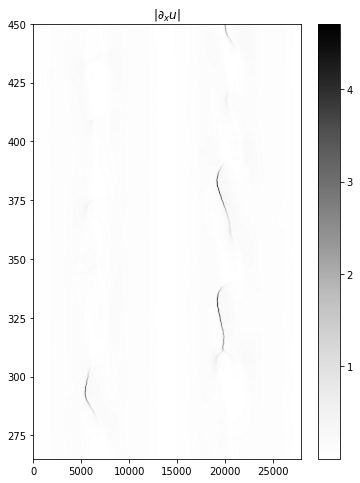

In [39]:
plt.figure(figsize=(6.,8))
plt.pcolormesh(x/1e3,t[it0:]/86400,abs(np.gradient(ua[it0:],axis=1)),shading='Gouraud',cmap='Greys')
plt.colorbar()
plt.ylim(265,450)
plt.title("$|\partial_x u|$")

In [40]:
print(np.mean((np.gradient(F[it0:],axis=1))),np.std((np.gradient(F[it0:],axis=1))))

-8.021035360350482e-08 1.0514530631330006


Text(0.5,1,'$\\left(\\partial_x F - <\\partial_x F>\\right)/\\sigma_{\\partial_x F}$')

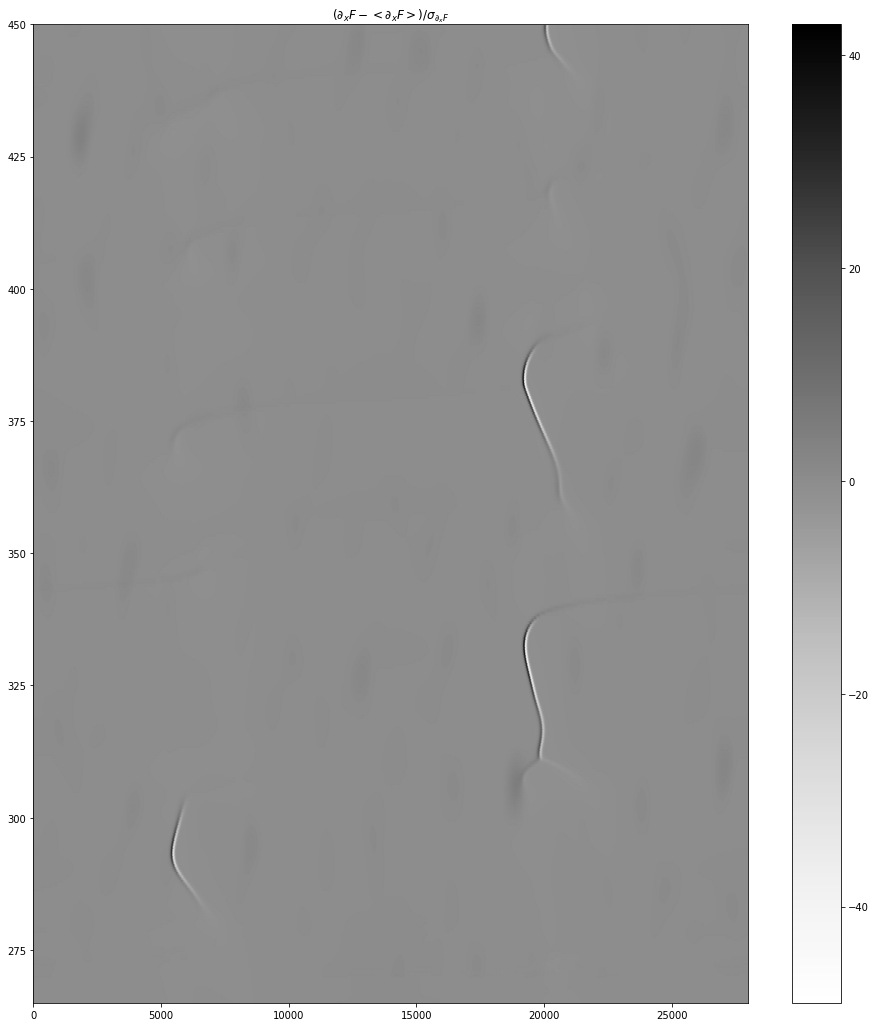

In [41]:
plt.figure(figsize=(16.,18))
grad = (np.gradient(F[it0:],axis=1))
plt.pcolormesh(x/1e3,t[it0:]/86400,((grad-np.mean(grad))/np.std(grad)),shading='Gouraud',cmap='Greys')
plt.colorbar()
plt.ylim(265,450)
#plt.xlim(14000,24000)
plt.title("$\left(\partial_x F - <\partial_x F>\\right)/\sigma_{\partial_x F}$")

Text(0.5,1,'$\\left(<\\partial_x u> - \\partial_xu\\right)/\\sigma_{\\partial_x u}$')

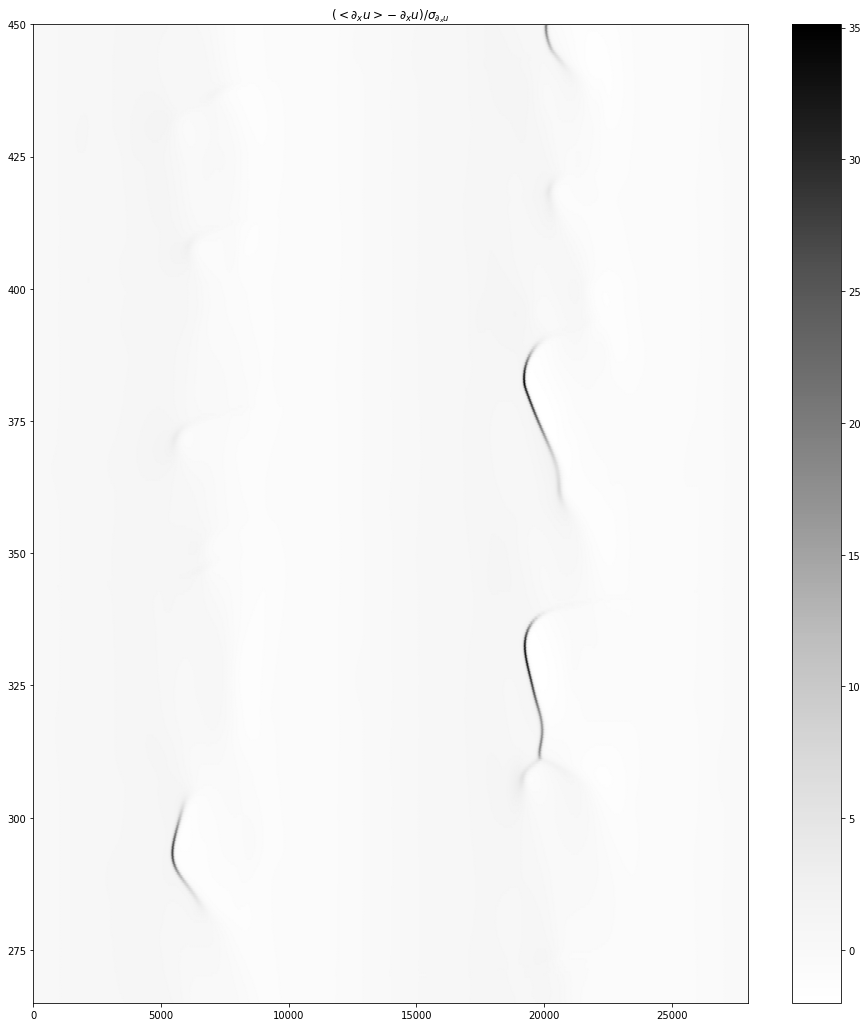

In [42]:
plt.figure(figsize=(16.,18))
ugrad = -(np.gradient(ua[it0:],axis=1))
plt.pcolormesh(x/1e3,t[it0:]/86400,((ugrad-np.mean(ugrad))/np.std(ugrad)),shading='Gouraud',cmap='Greys')
plt.colorbar()
plt.ylim(265,450)
#plt.xlim(14000,24000)
plt.title("$\left(<\partial_x u> - \partial_xu\\right)/\sigma_{\partial_x u}$")

Text(0.5,1,'$\\left(\\partial_x F - <\\partial_x F>\\right)/\\sigma_{\\partial_x F}$ > 10 Binary Flag')

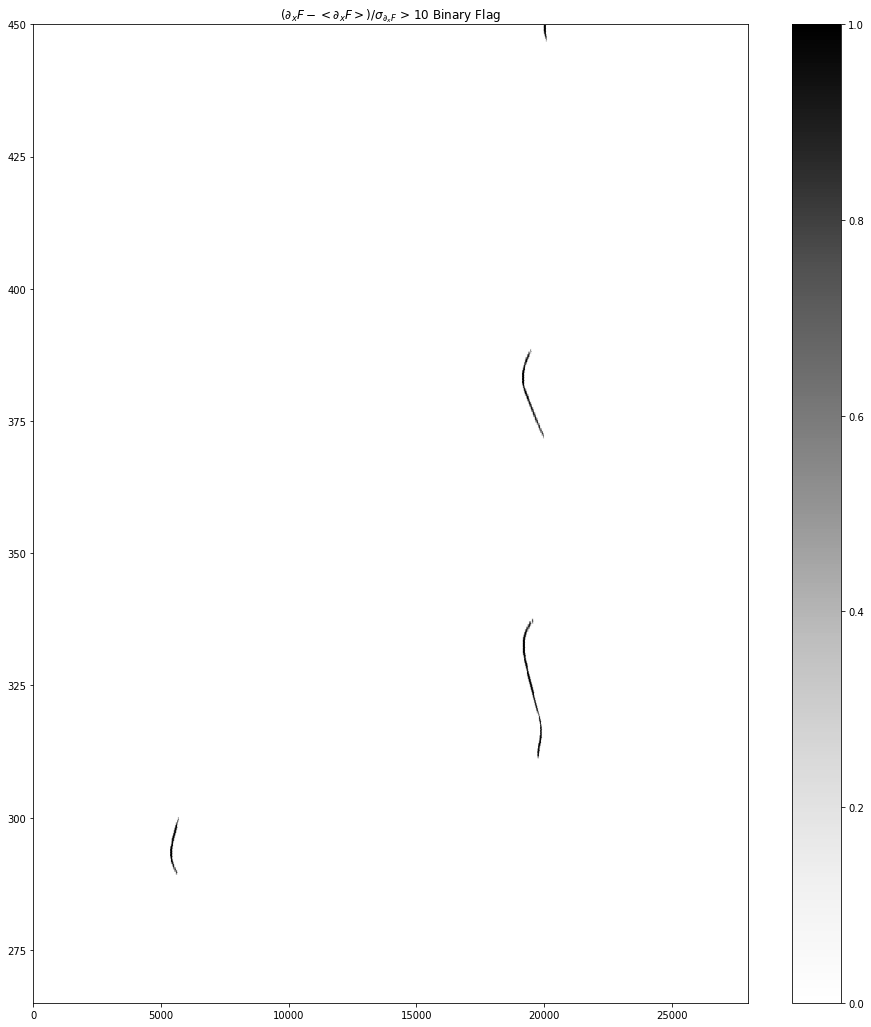

In [43]:
plt.figure(figsize=(16.,18))
thresh = 10
grad = (np.gradient(F[it0:],axis=1))
plt.pcolormesh(x/1e3,t[it0:]/86400,((grad-np.mean(grad))/np.std(grad) > thresh)*1.0,shading='Gouraud',cmap='Greys')
plt.colorbar()
plt.ylim(265,450)
#plt.xlim(14000,24000)
plt.title("$\left(\partial_x F - <\partial_x F>\\right)/\sigma_{\partial_x F}$ > %d Binary Flag"%thresh)

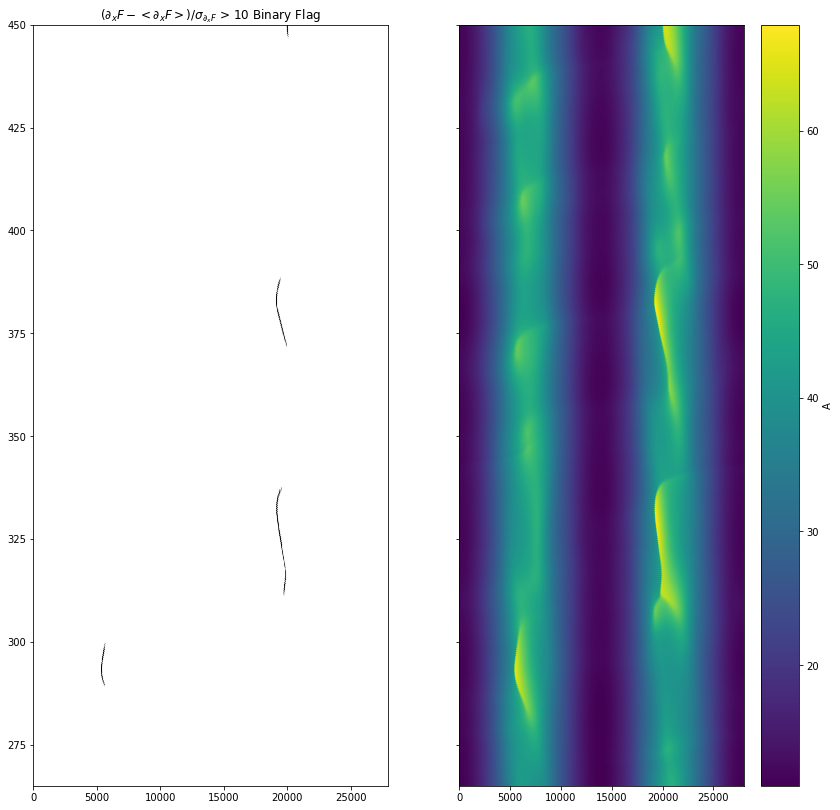

In [44]:
fix,axes=plt.subplots(1,2,figsize=(14,14),sharey=True)

im1=axes[0].pcolormesh(x/1e3,t[it0:]/86400,((grad-np.mean(grad))/np.std(grad) > thresh)*1.0,shading='Gouraud',cmap='Greys')
axes[0].set_ylim(265,450)
axes[0].set_title("$\left(\partial_x F - <\partial_x F>\\right)/\sigma_{\partial_x F}$ > %d Binary Flag"%thresh)
im2 = axes[1].pcolormesh(x/1e3,t[it0:]/86400,(Ahat+model.A0[np.newaxis,:])[it0:],shading='Gouraud',cmap='viridis')
axes[1].set_ylim(265,450)
plt.colorbar(im2,ax=axes[1],label="A")

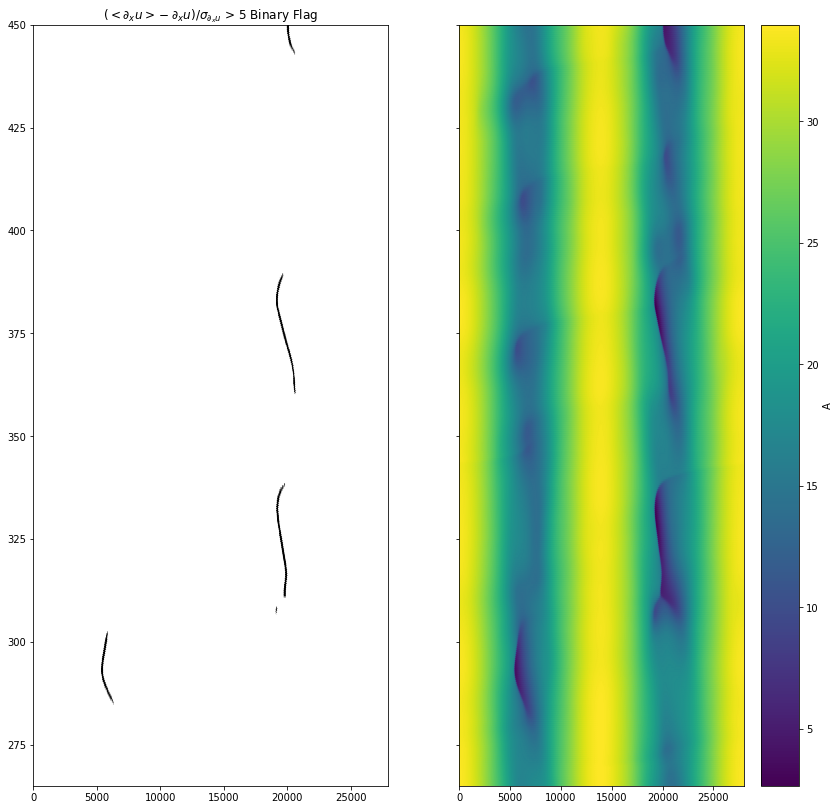

In [45]:
fix,axes=plt.subplots(1,2,figsize=(14,14),sharey=True)
threshu = 5
im1=axes[0].pcolormesh(x/1e3,t[it0:]/86400,((ugrad-np.mean(ugrad))/np.std(ugrad) > threshu)*1.0,shading='Gouraud',cmap='Greys')
axes[0].set_ylim(265,450)
axes[0].set_title("$\left(<\partial_x u> - \partial_xu\\right)/\sigma_{\partial_x u}$ > %d Binary Flag"%threshu)
im2 = axes[1].pcolormesh(x/1e3,t[it0:]/86400,ua[it0:],shading='Gouraud',cmap='viridis')
axes[1].set_ylim(265,450)
plt.colorbar(im2,ax=axes[1],label="A")

In [46]:
fmask = ((grad-np.mean(grad))/np.std(grad) > thresh)*1.0

In [47]:
ict,dmask = count_blocks(fmask,80,10)

In [48]:
print(ict)

4.0


In [49]:
umask = ((ugrad - np.mean(ugrad))/np.std(ugrad) > threshu)*1.0
uct,umask = count_blocks(umask,58,10)
print(uct)
uts = t[it0:][np.where(umask>0.5)[0]]/86400
uxs = x[np.where(umask>0.5)[1]]/1e3

4.0


In [50]:

ts = t[it0:][np.where(dmask>0.5)[0]]/86400
xs = x[np.where(dmask>0.5)[1]]/1e3
print(ts,xs)

[289.75 311.75 372.25 447.25] [ 5632.8125  19796.875   19988.28125 20097.65625]


/home/adiv/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Text(0.5,1,'$\\left(\\partial_x F - <\\partial_x F>\\right)/\\sigma_{\\partial_x F}$ > 10 Binary Flag')

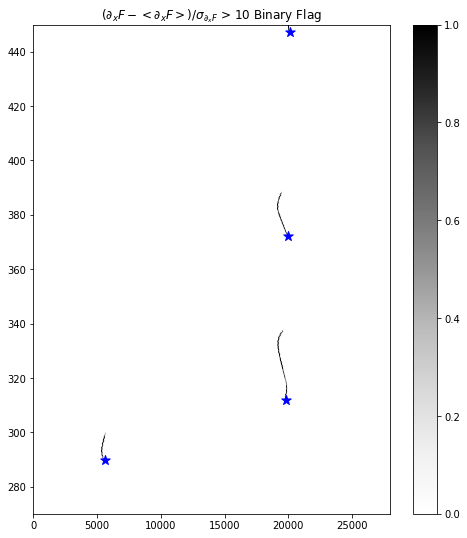

In [51]:
plt.figure(figsize=(8.,9))
grad = (np.gradient(F[it0:],axis=1))
blank = np.zeros(masked.shape)
blank[it0+250:it0+260,1300:1380] = 1.0
plt.pcolormesh(x/1e3,t[it0:]/86400,((grad-np.mean(grad))/np.std(grad) > thresh)*1.0,shading='Gouraud',cmap='Greys')
plt.colorbar()
plt.contour(x/1e3,t[it0:]/86400,blank[it0:],(0.5,),colors='r')
plt.scatter(xs,ts,s=100,marker='*',color='b')
plt.ylim(270,450)
#plt.xlim(14000,24000)
plt.title("$\left(\partial_x F - <\partial_x F>\\right)/\sigma_{\partial_x F}$ > %d Binary Flag"%thresh)

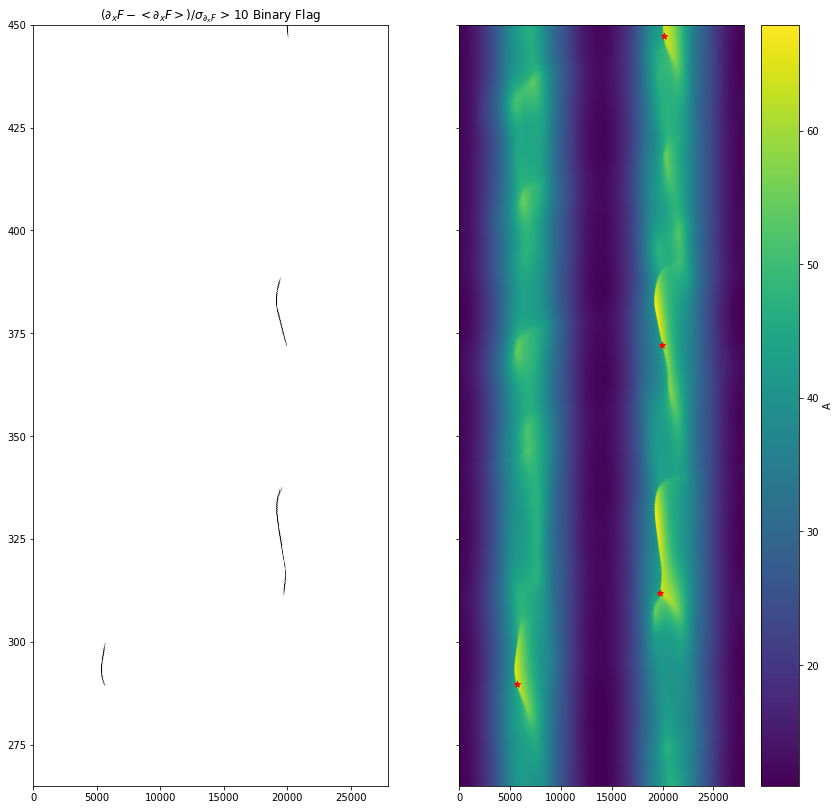

In [52]:
fix,axes=plt.subplots(1,2,figsize=(14,14),sharey=True)

im1=axes[0].pcolormesh(x/1e3,t[it0:]/86400,((grad-np.mean(grad))/np.std(grad) > thresh)*1.0,shading='Gouraud',cmap='Greys')
axes[0].set_ylim(265,450)
axes[0].set_title("$\left(\partial_x F - <\partial_x F>\\right)/\sigma_{\partial_x F}$ > %d Binary Flag"%thresh)
im2 = axes[1].pcolormesh(x/1e3,t[it0:]/86400,(Ahat+model.A0[np.newaxis,:])[it0:],shading='Gouraud',cmap='viridis')
axes[1].scatter(xs,ts,s=40,marker='*',color='r')
axes[1].set_ylim(265,450)
plt.colorbar(im2,ax=axes[1],label="A")

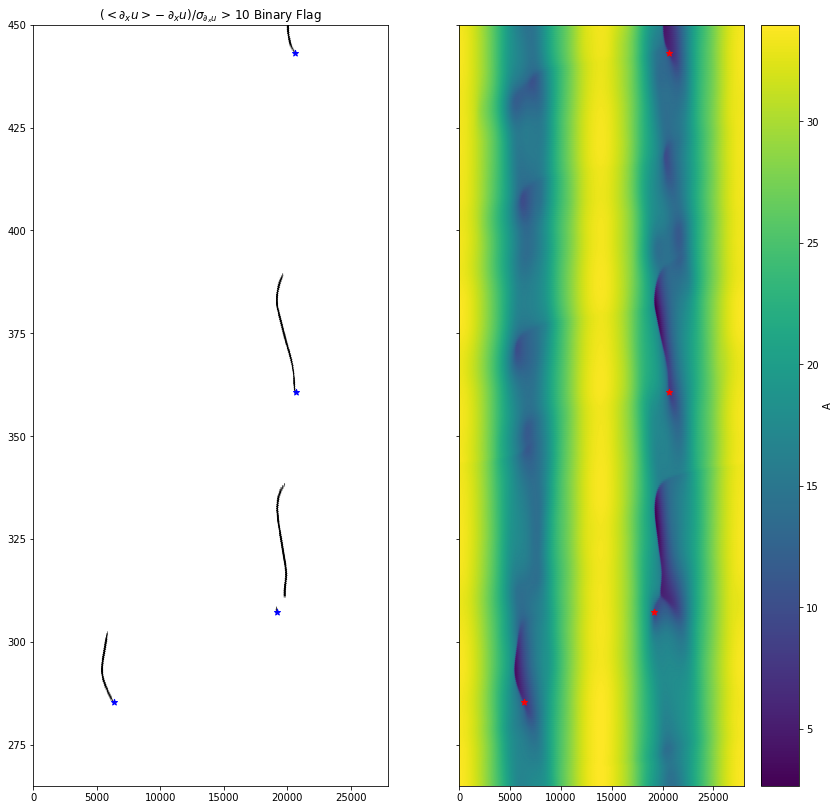

In [53]:
fix,axes=plt.subplots(1,2,figsize=(14,14),sharey=True)

im1=axes[0].pcolormesh(x/1e3,t[it0:]/86400,((ugrad-np.mean(ugrad))/np.std(ugrad) > threshu)*1.0,shading='Gouraud',cmap='Greys')
axes[0].set_ylim(265,450)
axes[0].set_title("$\left(<\partial_x u> - \partial_xu\\right)/\sigma_{\partial_x u}$ > %d Binary Flag"%thresh)
im2 = axes[1].pcolormesh(x/1e3,t[it0:]/86400,ua[it0:],shading='Gouraud',cmap='viridis')
axes[0].scatter(uxs,uts,s=40,marker='*',color='b')
axes[1].scatter(uxs,uts,s=40,marker='*',color='r')
axes[1].set_ylim(265,450)
plt.colorbar(im2,ax=axes[1],label="A")